True
(555, 383)
(555, 383)
RGB
L


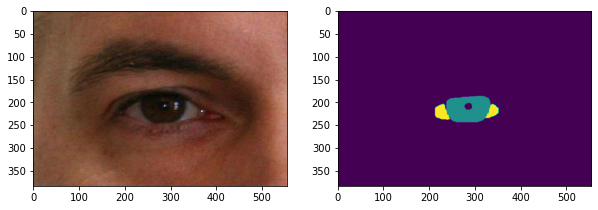

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch 

print(torch.cuda.is_available())

image = Image.open("/mnt/c/Users/kokun/Desktop/Project/tutorial_mask_rcnn_pytorch/datasets/ubiris_practice_2/ubiris_peculiar(jpg)/C1_S1_I1_L.jpg")
mask = Image.open("/mnt/c/Users/kokun/Desktop/Project/tutorial_mask_rcnn_pytorch/datasets/ubiris_practice_2/ubiris_peculiar(png)/C1_S1_I1_L.png")


plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(mask)

print(image.size)
print(mask.size)
# print(type(image))
print(image.mode)
print(mask.mode)

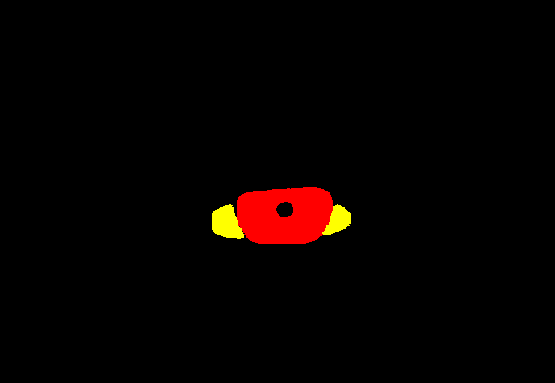

In [2]:
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red　←RGBの具体的な値ではなくカラーパレットのIDが格納されている！だから視覚的には、真っ黒にしか見えない。
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])

mask

In [61]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # 画像の並び方を揃えるために、すべての画像ファイルをロードしてソートします
        self.imgs = list(sorted(os.listdir(os.path.join(root, "ubiris_peculiar(jpg)"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "ubiris_peculiar(png)"))))

    def __getitem__(self, idx):
        # 画像とマスクをロードします
        img_path = os.path.join(self.root, "ubiris_peculiar(jpg)", self.imgs[idx])
        mask_path = os.path.join(self.root, "ubiris_peculiar(png)", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # 各色は異なるインスタンスに対応しているため、なお、値が0になっているインスタンスは背景となります。
        mask = Image.open(mask_path)# マスクに対してはRGBに変換していない点に注意してください。
        
        
        
        mask = np.array(mask)# PIL 画像を numpy 配列に変換します
        obj_ids = np.unique(mask)# インスタンスは異なる色でエンコードされています
        # print(obj_ids) #[0 1 2]
        obj_ids = obj_ids[1:]# 最初のIDは背景なので削除します
        # print(obj_ids) #[1 2]

        masks = mask == obj_ids[:, None, None]# カラー・エンコードされたマスクを、True/Falseで表現されたマスクに変換します
        # print("masks:",masks)

        # 各マスクのバウンディングボックスの座標を取得します
        num_objs = len(obj_ids)
        print(num_objs)
        # num_objs = 1 # クラス数を1とする。
        
        boxes = []
    
        for i in range(num_objs):
            pos = np.where(masks[i])
            print("pos:",pos)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        
        # すべてtorch.Tensorに変換します
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # クラスは今回は1つだけ（人物）です　→ 虹彩と結膜の2つに変更
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # すべてのインスタンスを、iscrowd=0と仮定します
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [62]:
dataset = PennFudanDataset('datasets/ubiris_practice_2/')
dataset[0]

2
pos: (array([289, 289, 289, ..., 378, 378, 378]), array([449, 450, 451, ..., 391, 392, 393]))
pos: (array([314, 314, 314, ..., 368, 368, 368]), array([321, 322, 323, ..., 339, 340, 341]))


(<PIL.Image.Image image mode=RGB size=849x586 at 0x7FD705125EE0>,
 {'boxes': tensor([[334., 289., 489., 378.],
          [291., 314., 517., 368.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([13795., 12204.]),
  'iscrowd': tensor([0, 0])})

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
# COCOデータセットで訓練した、訓練済みモデルをロード
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# 既存の分類器を、ユーザーが定義したnum_classesを持つ新しい分類器に置き換えます

# num_classes = 2  # 人を示すクラス＋背景クラスで2個                                              これでいいの？？？？
num_classes = 3  # 虹彩+結膜+背景で3個

# 分類器にインプットする特徴量の数を取得
in_features = model.roi_heads.box_predictor.cls_score.in_features
# 事前訓練済みのヘッドを新しいものと置き換える
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
#___________________________________________________________________________________________
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
 
# 分類のために訓練済みモデルをロードし、特徴量のみを取得します。
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNNでは、バックボーンで指定された出力チャネル数を知る必要があります。
# mobilenet_v2の場合は1280なので、ここで1280を設定します。
backbone.out_channels = 1280
 
# RPN：Resion Proposal Networkに、空間ごとに5 x 3パターンのアンカーを生成させてみましょう。
# これは、アンカーに5つのサイズ（size）と、3つのアスペクト比(aspect_ratio)があることを意味します。
# 特徴マップごとに異なるサイズとアスペクト比となる可能性があるので，Tuple[Tuple[int]] という形式で指定します。
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
 
# 関心領域のトリミングを実行するために使用する特徴マップ(featmap_names)と、
# 画像の大きさを元に戻した後のトリミングのサイズ(output_size)を定義しましょう。
# バックボーンがTensorを返す場合、featmap_namesは[0]になっているはずです。
# もう少し一般化して説明すると、バックボーンはOrderedDict[Tensor]を返すことになるので、
# featmap_namesで使用する特徴マップを選択できます。
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)
 
# FasterRCNNモデルに上記に定義したパーツをまとめます。
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
#___________________________________________________________________________________________
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_instance_segmentation_model(num_classes):
    # COCOデータセットで事前学習したインスタンス・セグメンテーションのモデルをロードします
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # 分類器に入力する特徴量の数を取得します
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # 事前訓練済みのヘッドを新しいヘッドに置き換えます
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # セグメンテーション・マスクの分類器に入力する特徴量の数を取得します
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # セグメテーション・マスクの推論器を新しいものに置き換えます
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model
#___________________________________________________________________________________________
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # PIL imageをPyTorch Tensorに変換します
    transforms.append(T.ToTensor())
    if train:
        # 訓練中、データオーギュメンテーションとして、
        # 訓練用の画像と正解のバウンディング・ボックスをランダム確率で水平に反転させます
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [7]:
# 作成したカスタム・データセット
dataset = PennFudanDataset('datasets/ubiris_practice_2/', get_transform(train=True))
dataset_test = PennFudanDataset('datasets/ubiris_practice_2/', get_transform(train=False))

# データセットを訓練セットとテストセットに分割
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

In [8]:
# 訓練データと評価データのデータロード用オブジェクトを用意
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device#gpuが作動しているかの確認

device(type='cuda')

In [10]:
# num_classes = 2  # 作成したカスタム・データセットのクラスは、背景と人の2クラスのみです = 背景と虹彩の2クラスのみ
num_classes = 3  # 虹彩+結膜+背景で3個

# 補助関数を使って、モデルを取得します
model = get_instance_segmentation_model(num_classes)

# モデルを正しいデバイス(GPU)に移動します
model.to(device)

# オプティマイザを定義します
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# 3エポックごとに学習率が1/10になるように学習率スケジューラを定義します
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [11]:
# 10エポックで訓練してみましょう
num_epochs = 5
    
for epoch in range(num_epochs):
    # １エポックの訓練につき、10イテレーションごとにprintします
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # 学習率の更新
    lr_scheduler.step()
    # テストデータセットの評価
    evaluate(model, data_loader_test, device=device)

22
2

pos:pos: pos: 2 (array([172, 172, 172, ..., 229, 229, 230]), array([287, 288, 289, ..., 303, 304, 291]))(array([200, 200, 200, ..., 265, 265, 265]), array([329, 330, 331, ..., 357, 358, 359]))

(array([229, 229, 229, ..., 307, 307, 307]), array([338, 339, 340, ..., 343, 344, 345]))

pos:pos:pos:pos:    (array([187, 187, 187, ..., 225, 225, 225]), array([229, 230, 231, ..., 245, 246, 247]))(array([214, 214, 214, ..., 259, 259, 259]), array([283, 284, 285, ..., 387, 388, 389]))(array([249, 249, 249, ..., 304, 304, 304]), array([267, 268, 269, ..., 291, 292, 293]))
(array([258, 258, 258, ..., 326, 326, 326]), array([361, 362, 363, ..., 396, 397, 398]))


pos: (array([279, 279, 279, ..., 319, 319, 319]), array([462, 463, 464, ..., 463, 464, 465]))
2
pos: (array([187, 187, 187, ..., 243, 243, 243]), array([303, 304, 305, ..., 303, 304, 305]))
pos: (array([204, 204, 204, ..., 238, 238, 238]), array([229, 230, 337, ..., 238, 239, 240]))
2
pos: (array([162, 162, 162, ..., 225, 225, 225])

/mnt/c/Users/kokun/Desktop/pytorch_tutorial_torchvision/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


2
pos: (array([205, 205, 205, ..., 262, 262, 262]), array([197, 198, 199, ..., 246, 247, 248]))
pos: (array([216, 216, 216, ..., 259, 259, 259]), array([164, 165, 166, ..., 284, 285, 286]))
2
pos: (array([252, 252, 252, ..., 325, 325, 325]), array([349, 350, 351, ..., 382, 383, 384]))
pos: (array([272, 272, 272, ..., 318, 318, 318]), array([293, 294, 295, ..., 426, 427, 428]))
Epoch: [0]  [ 0/20]  eta: 0:00:37  lr: 0.000268  loss: 3.9673 (3.9673)  loss_classifier: 0.8854 (0.8854)  loss_box_reg: 0.1223 (0.1223)  loss_mask: 2.7476 (2.7476)  loss_objectness: 0.1923 (0.1923)  loss_rpn_box_reg: 0.0197 (0.0197)  time: 1.8805  data: 0.2661  max mem: 2123
2
pos: (array([232, 232, 232, ..., 300, 300, 300]), array([344, 345, 346, ..., 362, 363, 364]))
pos: (array([255, 255, 256, 256, 256, 256, 256, 256, 256, 257, 257, 257, 257,
       257, 257, 257, 257, 257, 258, 258, 258, 258, 258, 258, 258, 258,
       258, 259, 259, 259, 259, 259, 259, 259, 259, 259, 260, 260, 260,
       260, 260, 260, 260,

In [32]:
img, _  = dataset_test[0]

2
pos: (array([302, 302, 302, ..., 394, 394, 394]), array([280, 281, 282, ..., 360, 361, 362]))
pos: (array([328, 328, 328, ..., 396, 396, 396]), array([238, 239, 240, ..., 406, 407, 408]))


{'boxes': tensor([[255., 302., 409., 394.],
         [235., 328., 465., 396.]]),
 'labels': tensor([1, 1]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'image_id': tensor([33]),
 'area': tensor([14168., 15640.]),
 'iscrowd': tensor([0, 0])}

In [59]:
# テストセット用に、画像を一つ取得します
img, _ = dataset_test[0]

# モデルを評価モードに変更します
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

# plt.figure(figsize=(10,10))
# plt.subplot(1,2,1)
# plt.imshow(Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()))
# plt.subplot(1,2,2)
# plt.imshow(Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()))

2
pos: (array([302, 302, 302, ..., 394, 394, 394]), array([280, 281, 282, ..., 360, 361, 362]))
pos: (array([328, 328, 328, ..., 396, 396, 396]), array([238, 239, 240, ..., 406, 407, 408]))


In [60]:
prediction[0]

{'boxes': tensor([[258.7189, 300.4774, 405.0616, 392.7273],
         [370.8639, 341.4533, 481.1264, 402.4516],
         [242.0576, 307.0955, 495.2030, 403.1759],
         [398.2771, 336.0594, 451.1807, 402.9759],
         [237.4921, 336.7731, 433.1104, 398.8224],
         [321.6184, 349.5404, 523.2665, 404.6905],
         [424.5150, 349.1767, 498.5082, 403.2596],
         [261.5366, 178.1432, 399.9439, 407.4414],
         [350.3922, 308.3182, 442.8228, 403.5370],
         [297.7390, 281.0153, 377.8034, 384.9814],
         [304.0531, 302.0367, 364.9176, 352.2108]], device='cuda:0'),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9842, 0.9107, 0.7645, 0.4744, 0.4630, 0.3330, 0.2048, 0.1322, 0.0918,
         0.0700, 0.0693], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
        

In [53]:
array = np.array(prediction[0]["masks"])
np.where(array==1)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

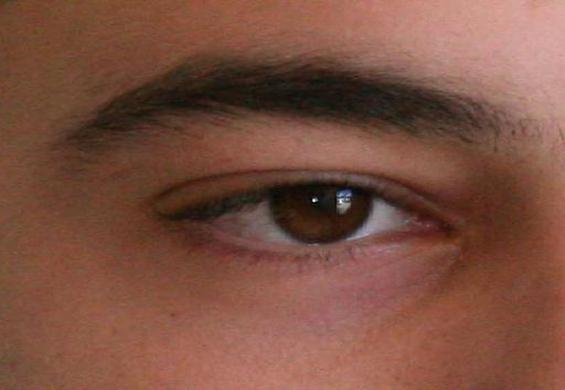

In [44]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

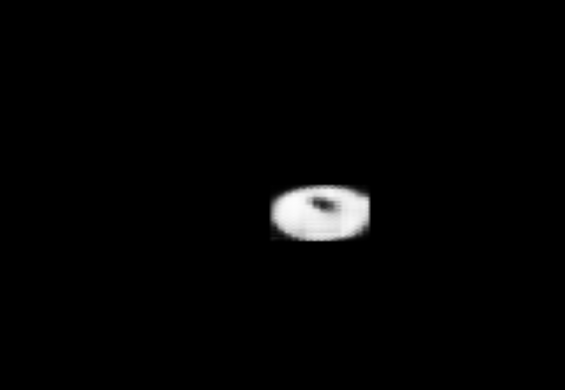

In [45]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
#numpyの配列から画像を生成するfromarray()という関数
#mul←掛け算？

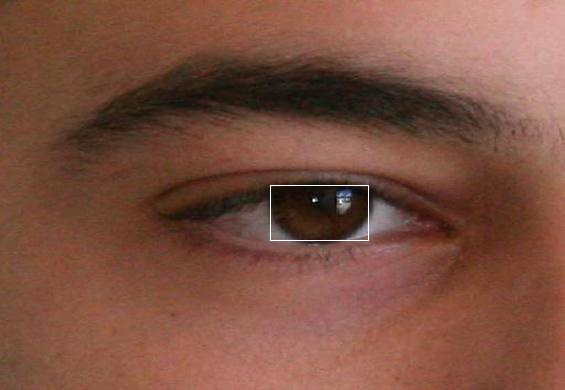

In [46]:
from PIL import ImageDraw
im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

draw = ImageDraw.Draw(im)
draw.rectangle(prediction[0]['boxes'][0].cpu().numpy())

im

8
tensor([0.9918, 0.8109, 0.4905, 0.1273, 0.1035, 0.1002, 0.0538, 0.0522],
       device='cuda:0')


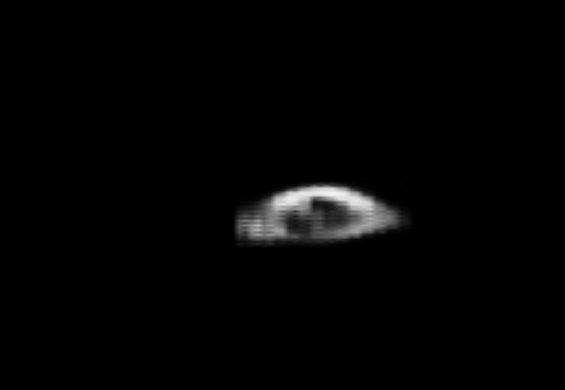

In [47]:
# 日本語訳注：検出された物体は2つで、確信度は0.99と0.48です。
print(len(prediction[0]['masks']))
print(prediction[0]['scores'])

# 確信度0.48の人物のマスクを描画します。
# 元の画像を見ると、確かに奥の方に人がいるような気がします
Image.fromarray(prediction[0]['masks'][1, 0].mul(255).byte().cpu().numpy())